# Data Imputation - Age

In [1]:
import pandas as pd

df = pd.read_csv("../../data/raw/train.csv")
dfX = df.drop(['Survived', 'PassengerId'], axis=1)
dfy = df.Survived

In [2]:
from src.plotting import plot_missprop

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

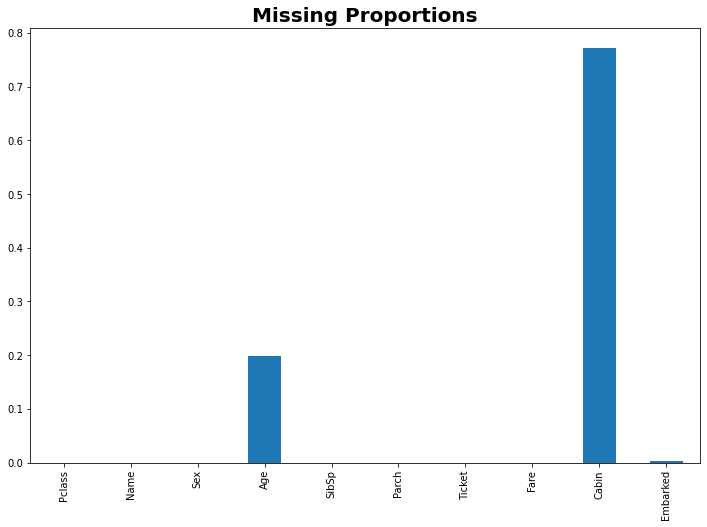

In [3]:
plot_missprop(dfX)

In [4]:
from src.prepare import drop_NA_Embarked

In [5]:
from sklearn.impute import KNNImputer

In [6]:
from src.pipeline import dp1 as dp
from src.utils import print_params

In [7]:
dp.get_description(markdown=True)


1. Drop Name, Ticket - requires Feature Engineering
2. OneHotEncoder for Sex, Embarked
3. Drop Cabin - requires Feature Engineering/(?And Not Imputation)
4. Age : Applied Mean Imputation and Mean Normalization
5. Drop NaN rows in Embarked
6. Applied StandardScaler at the end to all features

MLmodel: SVC

In [8]:
dp.set_data(df)

In [9]:
print_params(dp)

['data',
 'description',
 'mlmodel',
 'prepare_data__memory',
 'prepare_data__steps',
 'prepare_data__verbose',
 'prepare_data__nan_drpr',
 'prepare_data__nan_drpr__key',
 'prepare_data',
 'preprocess_data',
 'warn',
 'ycol',
 'preprocess',
 'ml',
 'preprocess__memory',
 'preprocess__steps',
 'preprocess__verbose',
 'preprocess__clmn_trnsfrm',
 'preprocess__scale',
 'preprocess__clmn_trnsfrm__n_jobs',
 'preprocess__clmn_trnsfrm__remainder',
 'preprocess__clmn_trnsfrm__sparse_threshold',
 'preprocess__clmn_trnsfrm__transformer_weights',
 'preprocess__clmn_trnsfrm__transformers',
 'preprocess__clmn_trnsfrm__verbose',
 'preprocess__clmn_trnsfrm__clmn_drp',
 'preprocess__clmn_trnsfrm__enc',
 'preprocess__clmn_trnsfrm__imp',
 'preprocess__clmn_trnsfrm__enc__categories',
 'preprocess__clmn_trnsfrm__enc__drop',
 'preprocess__clmn_trnsfrm__enc__dtype',
 'preprocess__clmn_trnsfrm__enc__handle_unknown',
 'preprocess__clmn_trnsfrm__enc__sparse',
 'preprocess__clmn_trnsfrm__imp__add_indicator',
 '

## Try different imputers for Age

1. SimpleImputer
2. KNNImputer
3. IterativeImputer

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import GridSearchCV
import numpy as np

### Can't use IterativeImputer this way in the current pipeline

In [11]:
param_grid = [
    {
        'preprocess__clmn_trnsfrm__imp': [KNNImputer()],
        'preprocess__clmn_trnsfrm__imp__n_neighbors': range(3, 15, 2)
    }, 
    {
        'preprocess__clmn_trnsfrm__imp': [SimpleImputer()],
        'preprocess__clmn_trnsfrm__imp__strategy': ['mean', 'median']
    }]

In [12]:
grid = GridSearchCV(dp, param_grid, cv=5)
dfX_pre, dfy_pre = dp.prepare()
grid.fit(dfX_pre, dfy_pre)

GridSearchCV(cv=5, error_score=nan,
             ('estimator', DataPipeline),
             iid='deprecated', n_jobs=None,
             param_grid=[{'preprocess__clmn_trnsfrm__imp': [KNNImputer(add_indicator=False,
                                                                       copy=True,
                                                                       metric='nan_euclidean',
                                                                       missing_values=nan,
                                                                       n_neighbors=3,
                                                                       weights='uniform')],
                          'preprocess__clmn_trnsfrm__imp__n_neighbors': range(3, 15, 2)},
                         {'preprocess__clmn_trnsfrm__imp': [SimpleImputer(add_indicator=False,
                                                                          copy=True,
                                                                      

In [13]:
print(grid.best_score_)
print(grid.best_params_)

0.8200533231765377
{'preprocess__clmn_trnsfrm__imp': KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform'), 'preprocess__clmn_trnsfrm__imp__n_neighbors': 3}


## Using IterativeImputer 

To enable this on our current ```DataPipeline```, we need to modify it as following:
- ~Remove the ```NaNDropper``` step for the ```Embarked``` column as IterativeImputer will do it on it's own~ 
   We can't do that since we will be using OneHotEncoder on it
- Remove the Imputation from the Age column or any subsequent steps
- After the other columns are preprocessed, Use ```IterativeImputer``` on the whole dataset

### Let's see the datapipeline we have

In [14]:
# print_params(dp)

### Bypassing the ```NaNDropper``` step
I can write a class that just takes in a dataframe and returns the dataframe intact

In [15]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline


In [16]:
class NoPrepare(BaseEstimator):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if y is None:
            return X
        else:
            return X, y
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [17]:
# NoPrepare().fit_transform(dfX)

In [18]:
# dp.prepare_data = Pipeline([
#     ('no_prepare', NoPrepare())])

In [19]:
# dp.prepare()

## Removing the ```impute_scaler``` step from the ```Age``` column

In [20]:
print_params(dp)

['data',
 'description',
 'mlmodel',
 'prepare_data__memory',
 'prepare_data__steps',
 'prepare_data__verbose',
 'prepare_data__nan_drpr',
 'prepare_data__nan_drpr__key',
 'prepare_data',
 'preprocess_data',
 'warn',
 'ycol',
 'preprocess',
 'ml',
 'preprocess__memory',
 'preprocess__steps',
 'preprocess__verbose',
 'preprocess__clmn_trnsfrm',
 'preprocess__scale',
 'preprocess__clmn_trnsfrm__n_jobs',
 'preprocess__clmn_trnsfrm__remainder',
 'preprocess__clmn_trnsfrm__sparse_threshold',
 'preprocess__clmn_trnsfrm__transformer_weights',
 'preprocess__clmn_trnsfrm__transformers',
 'preprocess__clmn_trnsfrm__verbose',
 'preprocess__clmn_trnsfrm__clmn_drp',
 'preprocess__clmn_trnsfrm__enc',
 'preprocess__clmn_trnsfrm__imp',
 'preprocess__clmn_trnsfrm__enc__categories',
 'preprocess__clmn_trnsfrm__enc__drop',
 'preprocess__clmn_trnsfrm__enc__dtype',
 'preprocess__clmn_trnsfrm__enc__handle_unknown',
 'preprocess__clmn_trnsfrm__enc__sparse',
 'preprocess__clmn_trnsfrm__imp__add_indicator',
 '

In [21]:
class NoPrepare(BaseEstimator):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [22]:
NoPrepare().fit_transform(df.loc[:, ['Age']])

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,NaN
889,26.0


~```preprocessing__imp_scaler```~ ---**BUG** ---  ~```preprocess_data__imp_scaler```~ ---**BUG** --- is the specific hyperparameter we want to remove. 

We can do that using
```NoPrepare```

In [23]:
# dp.set_params(**{'preprocessing__imp_scaler': NoPrepare()})

We can modify the ```preprocess_data``` column transformer to set ```imp_scalar``` to ```NoPrepare()```


In [24]:
print_params(dp.preprocess_data)

['memory',
 'steps',
 'verbose',
 'clmn_trnsfrm',
 'scale',
 'clmn_trnsfrm__n_jobs',
 'clmn_trnsfrm__remainder',
 'clmn_trnsfrm__sparse_threshold',
 'clmn_trnsfrm__transformer_weights',
 'clmn_trnsfrm__transformers',
 'clmn_trnsfrm__verbose',
 'clmn_trnsfrm__clmn_drp',
 'clmn_trnsfrm__enc',
 'clmn_trnsfrm__imp',
 'clmn_trnsfrm__enc__categories',
 'clmn_trnsfrm__enc__drop',
 'clmn_trnsfrm__enc__dtype',
 'clmn_trnsfrm__enc__handle_unknown',
 'clmn_trnsfrm__enc__sparse',
 'clmn_trnsfrm__imp__add_indicator',
 'clmn_trnsfrm__imp__copy',
 'clmn_trnsfrm__imp__fill_value',
 'clmn_trnsfrm__imp__missing_values',
 'clmn_trnsfrm__imp__strategy',
 'clmn_trnsfrm__imp__verbose',
 'scale__copy',
 'scale__with_mean',
 'scale__with_std']


In [25]:
from src.preprocessing import modify_transformer_est

In [26]:
dp.preprocess_data.set_params(**{'clmn_trnsfrm__imp': NoPrepare()})

Pipeline(memory=None,
         steps=[('clmn_trnsfrm',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('clmn_drp', 'drop',
                                                  ['Name', 'Ticket', 'Cabin']),
                                                 ('enc',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Sex', 'Embarked']),
                                                 ('im

In [27]:
dp.prepare()
dp.preprocess()

array([[ 0.73534203, -0.30794088,  0.61679395, ...,  0.43135024,
        -0.47432585, -0.50023975],
       [-1.35991138, -0.30794088, -1.62128697, ...,  0.43135024,
        -0.47432585,  0.78894661],
       [-1.35991138, -0.30794088,  0.61679395, ..., -0.47519908,
        -0.47432585, -0.48664993],
       ...,
       [-1.35991138, -0.30794088,  0.61679395, ...,  0.43135024,
         2.00611934, -0.17408416],
       [ 0.73534203, -0.30794088, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.0422126 ],
       [ 0.73534203,  3.24737656, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.49017322]])

Let's check if the preprocessed data has ```NaN``` values as expected in the ```Age``` column

In [28]:
np.isnan(dp.preprocess()).any()

True

So the ```prepare``` and ```preprocess``` steps are working fine. 

### Now we need to add an extra step of ```IterativeImputer``` after the ```preprocess``` step.

You can use any regressor as an ```estimator``` in ```IterativeImputer``` like ```LinearRegression```, ```Ridge```, ```RandomForestRegressor``` etc

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

In [30]:
preprocess_data = dp.preprocess_data
modified_preprocess = Pipeline([
    ('preprocess', preprocess_data),
    ('impute', IterativeImputer(DecisionTreeRegressor()))
]
)

dp.preprocess_data = modified_preprocess

In [31]:
dp.prepare()
dp.preprocess()

array([[ 0.73534203, -0.30794088,  0.61679395, ...,  0.43135024,
        -0.47432585, -0.50023975],
       [-1.35991138, -0.30794088, -1.62128697, ...,  0.43135024,
        -0.47432585,  0.78894661],
       [-1.35991138, -0.30794088,  0.61679395, ..., -0.47519908,
        -0.47432585, -0.48664993],
       ...,
       [-1.35991138, -0.30794088,  0.61679395, ...,  0.43135024,
         2.00611934, -0.17408416],
       [ 0.73534203, -0.30794088, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.0422126 ],
       [ 0.73534203,  3.24737656, -1.62128697, ..., -0.47519908,
        -0.47432585, -0.49017322]])

Let's check if the preprocessed data has no ```NaN``` values as expected after applying ```IterativeImputer```

In [32]:
np.isnan(dp.preprocess()).any()

False

### Now let us try fitting our modified ```DataPipeline``` 

In [33]:
dp.fit()
dp.score()

0.8447694038245219

So this works!

#### Let's check our crossvalidated accuracy

In [34]:
dfX_pre, dfy_pre = dp.prepare()

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(dp,dfX_pre, dfy_pre).mean()

0.8166761886624769

## Hyperparamater tuning using ```GridSearchCV```

In [33]:
%%time 

from sklearn.model_selection import GridSearchCV

max_features = [2, 4, 6]
n_estimators = [10, 50, 100, 125]
min_samples_split = [2, 5, 10, 20]
max_depth = [None, 5, 10, 25]
min_samples_leaf = [1, 2, 5]

param_grid = {
    'train': [RandomForestClassifier()],
    'train__max_features': max_features,
    'train__n_estimators': n_estimators,
    'train__min_samples_split': min_samples_split,
    'train__max_depth': max_depth,
    'train__min_samples_leaf': min_samples_leaf
}

grid = GridSearchCV(dp, param_grid)
grid.fit(dfX, dfy)

print(grid.best_score)
print(grid.best_params_)


## Custom Imputation Strategy by Regressing 

 - I will use the ```DataFrameMapper``` from the ```sklearn-pandas``` library.
 - Using the ```DataFrameMapper``` will allow me to preserve the names of the dataframe.
 - Then I can easily impute the ```Age``` column by regressing against the other columns (leaving out predictant i.e. ```Survived```)
 
  To impute the ```Age``` column we need to 
  - Generate a preprocessed ```DataFrame``` using the ```DataFrameMapper``` so that I can identify the Age column
  - Divide the preprocessed ```DataFrame``` into two parts,
       - ```train``` set contains all rows with  ```No NA``` Age in them
       - ```test``` set contains the rows with ```NA``` Age in them 
  - ```Age``` is our ```y```, and the rest of the columns ```X```

In [38]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn_pandas import DataFrameMapper

In [39]:
from sklearn_pandas import DataFrameMapper
from src.utils import clmn_trnsfrmr_to_dfmapper

In [40]:
preprocess_data_dfm = clmn_trnsfrmr_to_dfmapper(preprocess_data.named_steps['clmn_trnsfrm'], 
                                                df_out=True, input_df=True)

BUG: When sparse=True

In [51]:
preprocess_data_dfm.features[0][1].set_params(sparse=False)

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

Since the ```remainder='passthrough'``` is not yet implemented, we need to explicity 
append the passthrough step for ```Age``` by setting the transformer to ```None```

In [52]:
dfX_pre

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
DataFrameMapper()

In [53]:
dfX_preproc = preprocess_data_dfm.fit_transform(dfX_pre)
dfX_preproc

,Sex_Embarked_x0_male,Sex_Embarked_x1_Q,Sex_Embarked_x1_S,Age,PassengerId,Pclass,Name,SibSp,Parch,Ticket,Fare,Cabin
0,1.0,0.0,1.0,22.0,1,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN
1,0.0,0.0,0.0,38.0,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85
2,0.0,0.0,1.0,26.0,3,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN
3,0.0,0.0,1.0,35.0,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123
4,1.0,0.0,1.0,35.0,5,3,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0.0,1.0,27.0,887,2,"Montvila, Rev. Juozas",0,0,211536,13.0000,NaN
887,0.0,0.0,1.0,19.0,888,1,"Graham, Miss. Margaret Edith",0,0,112053,30.0000,B42
888,0.0,0.0,1.0,NaN,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,2,W./C. 6607,23.4500,NaN
889,1.0,0.0,0.0,26.0,890,1,"Behr, Mr. Karl Howell",0,0,111369,30.0000,C148


**Note:** Since in the original ```preprocess_data``` ```ColumnTransformer```, since 
we performed the ```OneHotEncoding``` jointly for ```Sex``` and ```Embarked```, as 
```python  
('enc', OneHotEncoder(drop='first'), ['Sex', 'Embarked'])
```
So the column names we get are 
- ```Sex_Embarked_x0_male``` - which actually refers just ```Sex='Male'``` 
- ```Sex_Embarked_x1_Q``` - which actually refers just ```Embarked='Q'```

**WOW! This actually worked!!!** But we can make our transformers more suited for these tasks by implementing a ```get_feature_names``` for each transformer we define

### Create an estimator to impute  missing values based on supervised methods

```cross_val_score``` doesn't take input as a ```DataFrame```, so we need to provide a ```df_out``` argument

In [115]:
from sklearn.base import BaseEstimator

# TODO: Add support for lower and upper bounds?
class SupervisedImputer(BaseEstimator):
    '''Perform supervised imputation using any estimator
    
    Note: Currently only one column imputation is supported
    
    Parameters
    ----------
    
    estimator: an estimator object
    
    key_NA: str
        the column to impute provided as a string
        
    keys_nonNA: list
        the regressors for the imputation provided as a list of column keys
        
    df_out: bool default=False
        whether to return a dataframe or not
    '''
    
    def __init__(self ,estimator, key_NA, keys_nonNA=None, df_out=False):
        self.estimator = estimator
        self.key_NA = key_NA
        self.keys_nonNA = keys_nonNA
        self._has_no_NA = False
        self.df_out = df_out
        
        
    def fit(self, X, y=None, *args, **kwargs):
        
        X = X.dropna(subset=[self.key_NA])
        y = X.loc[:, self.key_NA]
        
        if self.keys_nonNA is None:
            X = X.drop(self.key_NA, axis=1)
        else:
            X = X.loc[:, self.keys_nonNA]
                    
        self.estimator.fit(X, y)
        
        return self
        
        
    def transform(self, X, y=None, *args, **kwargs):
        y = X.loc[:, self.key_NA]
        y_is_NA = y.isna()
        
        if not y_is_NA.any():
            return X        
        
        X =  X.copy()
        X_NA = X.loc[y_is_NA, :].drop(self.key_NA, axis=1)
        X.loc[y_is_NA, self.key_NA] = self.estimator.predict(X_NA)
        
        if not self.df_out:
            return X.values
        
        return X
    
    def fit_transform(self, X, y=None, *args, **kwargs):
        return self.fit(X, y, *args, **kwargs).transform(X, y, *args, **kwargs)

In [116]:
from sklearn.linear_model import Ridge

Supervised imputation with ```Ridge``` regression. We should possibly be able to tune it's ```hyperparameters``` too.

In [117]:
sup_imp = SupervisedImputer(Ridge(), 'Age')
sup_imp

SupervisedImputer(df_out=False,
                  estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                  max_iter=None, normalize=False,
                                  random_state=None, solver='auto', tol=0.001),
                  key_NA='Age', keys_nonNA=None)

In [118]:
sup_imp.fit_transform(dfX_preproc)

array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 22.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 38.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 26.        ],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         1.        , 16.48266917],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 26.        ],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.        , 32.        ]])

In [133]:
from sklearn.ensemble import RandomForestRegressor

Supervised imputation with ```RandomForestRegressor```

In [134]:
modified = Pipeline([
    ('preprocess', preprocess_data_dfm),
    ('impute', SupervisedImputer(RandomForestRegressor(), 'Age'))
])

modified.fit_transform(dfX_pre)

array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 22.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 38.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , 26.        ],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         1.        ,  8.38516667],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 26.        ],
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.        , 32.        ]])

In [135]:
dp.preprocess_data = modified

In [136]:
dfX_pre, dfy_pre = dp.prepare()
dp.preprocess()

array([[ 1.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 22.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , 38.    ],
       [ 0.    ,  0.    ,  1.    , ...,  0.    ,  0.    , 26.    ],
       ...,
       [ 0.    ,  0.    ,  1.    , ...,  0.    ,  1.    ,  7.7265],
       [ 1.    ,  0.    ,  0.    , ...,  0.    ,  0.    , 26.    ],
       [ 1.    ,  1.    ,  0.    , ...,  0.    ,  0.    , 32.    ]])

```train score```

In [137]:
dp.fit().score()

0.9910011248593926

```crossvalidated accuracy```

In [138]:
cross_val_score(dp, dfX_pre, dfy_pre).mean()

0.8065511331175014

Looks like ```DataFrameMapper``` doesn't include ```hyperparameters``` of the ```nested transformers```

In [147]:
print_params(dp)

['data',
 'description',
 'mlmodel',
 'prepare_data__memory',
 'prepare_data__steps',
 'prepare_data__verbose',
 'prepare_data__nan_drpr',
 'prepare_data__nan_drpr__key',
 'prepare_data',
 'preprocess_data',
 'ycol',
 'preprocessing',
 'train',
 'preprocessing__memory',
 'preprocessing__steps',
 'preprocessing__verbose',
 'preprocessing__preprocess',
 'preprocessing__impute',
 'preprocessing__preprocess__default',
 'preprocessing__preprocess__df_out',
 'preprocessing__preprocess__features',
 'preprocessing__preprocess__input_df',
 'preprocessing__preprocess__sparse',
 'preprocessing__impute__df_out',
 'preprocessing__impute__estimator__bootstrap',
 'preprocessing__impute__estimator__ccp_alpha',
 'preprocessing__impute__estimator__criterion',
 'preprocessing__impute__estimator__max_depth',
 'preprocessing__impute__estimator__max_features',
 'preprocessing__impute__estimator__max_leaf_nodes',
 'preprocessing__impute__estimator__max_samples',
 'preprocessing__impute__estimator__min_impuri

In [146]:
%autoreload 2